In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import scipy
import re
from scipy import spatial
from scipy.linalg import triu 
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
tokenizer = ToktokTokenizer()
import gensim
from gensim.models import Word2Vec , KeyedVectors
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import linear_kernel
import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
data=pd.read_csv("flipkart_com-ecommerce_sample.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20002 entries, 0 to 20001
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  20000 non-null  object 
 1   crawl_timestamp          20000 non-null  object 
 2   product_url              20000 non-null  object 
 3   product_name             20000 non-null  object 
 4   product_category_tree    20000 non-null  object 
 5   pid                      20000 non-null  object 
 6   retail_price             19922 non-null  float64
 7   discounted_price         19922 non-null  float64
 8   image                    19997 non-null  object 
 9   is_FK_Advantage_product  20000 non-null  object 
 10  description              19998 non-null  object 
 11  product_rating           20000 non-null  object 
 12  overall_rating           20000 non-null  object 
 13  brand                    14136 non-null  object 
 14  product_specifications

In [3]:
# made a new length column to give the total length of the 'description'
data['length']=data['description'].str.len()

In [4]:
# extraction of no of words 
data['no_of_words'] = data.description.apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)

In [5]:
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,length,no_of_words
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ...",410.0,64
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati...",4433.0,752
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""...",650.0,107
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ...",403.0,63
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",...",248.0,40


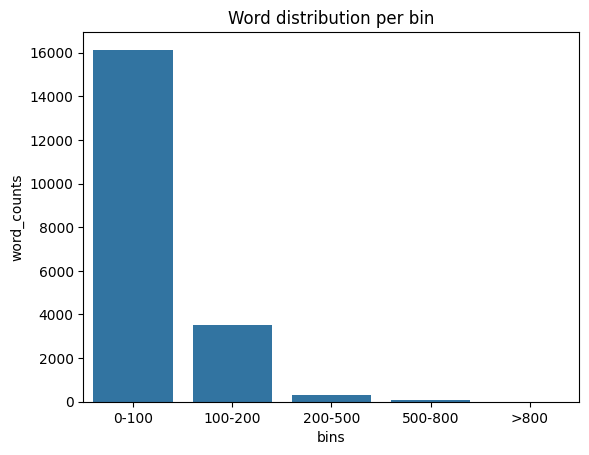

In [6]:
bins=[0,50,75, np.inf]
data['bins']=pd.cut(data.no_of_words, bins=[0,100,300,500,800, np.inf],
labels=['0-100', '100-200', '200-500','500-800' ,'>800'])
words_distribution = data.groupby('bins').size().reset_index().rename(columns={0:'word_counts'})
sns.barplot(x='bins', y='word_counts', data=words_distribution).set_title("Word distribution per bin")
plt.show()

# Data Preprocessing

In [7]:
# Number of missing values in each column
missing = pd.DataFrame(data.isnull().sum()).rename(columns = {0:'missing'})

In [8]:
# Create a percentage of missing values
missing['percent'] = missing['missing'] / len(data)

In [9]:
# sorting the values in desending order to see highest count on the top
missing.sort_values('percent', ascending = False)

,missing,percent
brand,5866,0.293271
retail_price,80,0.004000
discounted_price,80,0.004000
product_specifications,16,0.000800
image,5,0.000250
bins,4,0.000200
description,4,0.000200
length,4,0.000200
overall_rating,2,0.000100
product_rating,2,0.000100


# Text Preprocessing

In [10]:
# Remove punctuation
data['description'] = data['description'].str.replace(r'[^\w\d\s]', ' ')

In [11]:
# Replace whitespace between terms with a single space
data['description'] = data['description'].str.replace(r'\s+', ' ')

In [12]:
# Remove leading and trailing whitespace
data['description'] = data['description'].str.replace(r'^\s+|\s+?$', '')

In [13]:
# converting to lower case
data['description'] = data['description'].str.lower()

In [14]:
# removing special characters from 'description' column
data['description'] = data['description'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)

In [15]:
data['description'].head()

0    key features of alisha solid womens cycling sh...
1    fabhomedecor fabric double sofa bed finish col...
2    key features of aw bellies sandals wedges heel...
3    key features of alisha solid womens cycling sh...
4    specifications of sicons all purpose arnica do...
Name: description, dtype: object

In [16]:
# Removing Stop words
stop = stopwords.words('english')
pattern = r'\b(?:{})\b'.format('|'.join(stop))
data['description'] = data['description'].str.replace(pattern, '')

In [17]:
# Removing single characters
data['description'] = data['description'].fillna('').astype(str)
data['description'] = data['description'].str.replace(r'\s+', ' ', regex=True)
data['description'] = data['description'].apply(lambda x: " ".join(word for word in x.split() if len(word) > 1))

In [18]:
# Removing domain related stop words from description
specific_stop_words = [ "rs","flipkart","buy","com","free","day","cash","replacement","guarantee","genuine","key","feature","delivery","products","product","shipping", "online","india","shop" , "of" , 'flipkartcom' ,'for','the','and','from','to', 'in','and', 'only','with','on', 'your', 'is','this','at' ,"it" , 'you']
data['description'] = data['description'].apply(lambda x: " ".join(x for x in x.split() if x not in specific_stop_words))

In [19]:
data['description'].head()

0    features alisha solid womens cycling shorts co...
1    fabhomedecor fabric double sofa bed finish col...
2    features aw bellies sandals wedges heel casual...
3    features alisha solid womens cycling shorts co...
4    specifications sicons all purpose arnica dog s...
Name: description, dtype: object

[('womens', 8088), ('30', 7743), ('features', 7190), ('price', 6696), ('color', 5578), ('details', 5297), ('type', 5248), ('casual', 4916), ('material', 4849), ('fabric', 4845)]


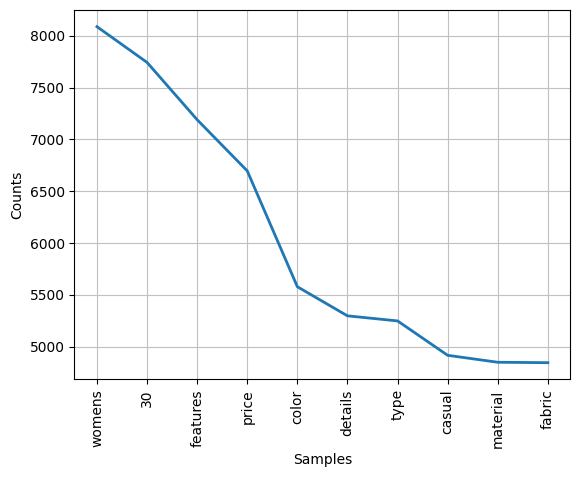

In [20]:
#Top frequent words after removing domain related stop words
a = data['description'].str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)
word_dist.plot(10,cumulative=False)
print(word_dist.most_common(10))

# Content-based Recommendation System

### TF-IDF approach

In [21]:
#text cleaning
data['description'] = data['description'].fillna('')

In [22]:
#define the vectorizer
T_vec = TfidfVectorizer(stop_words='english')

In [23]:
T_vec_matrix = T_vec.fit_transform(data['description'])

In [24]:
T_vec_matrix.shape

(20002, 32515)

In [25]:
# Reversing the map of indices and product
product_index = pd.Series(data.index, index=data['product_name']).drop_duplicates()
product_index

product_name
Alisha Solid Women's Cycling Shorts            0
FabHomeDecor Fabric Double Sofa Bed            1
AW Bellies                                     2
Alisha Solid Women's Cycling Shorts            3
Sicons All Purpose Arnica Dog Shampoo          4
                                           ...  
Elite Collection Medium Acrylic Sticker    19997
Elite Collection Medium Acrylic Sticker    19998
Elite Collection Medium Acrylic Sticker    19999
NaN                                        20000
NaN                                        20001
Length: 20002, dtype: int64

In [41]:
# Function that takes in product title as input and outputs the mostsimilar product
def predict_products(text):
 # getting index
 index = product_index[text]
 # Obtaining the pairwsie similarity scores
 score_matrix = linear_kernel(T_vec_matrix[index], T_vec_matrix)
 matching_sc= list(enumerate(score_matrix[0]))
 # Sort the product based on the similarity scores
 matching_sc= sorted(matching_sc, key=lambda x: x[1], reverse=True)
 # Getting the scores of the 10 most similar product
 matching_sc= matching_sc[1:10]
 # Getting the product indices
 product_indices = [i[0] for i in matching_sc]
 # Show the similar products
 return data['product_name'].iloc[product_indices]
recommended_product = predict_products(input("Welcome to flipkart tell me what you want"))
if recommended_product is not None:
 print ("products list")
 print("\n")
 for product_name in recommended_product:
   print (product_name)

Welcome to flipkart tell me what you want AW Bellies


products list


Shopnetix Stylish & Comfort Men's Lace up Mocassins (SNX-4449) Casuals
Bootwale Bellies
Bootwale Bellies
Bootwale Bellies
Bootwale Bellies
Bootwale Bellies
Lee Parke Running Shoes
Bootwale Bellies
BrandTrendz Bellies
